In [1]:
# SNN
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch.functional import quant
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen
from IPython.display import HTML
# Quantization
#import brevitas.nn as qnn

# Torch
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
# Other
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
batch_size = 128
data_path  = './data/mnist'
num_class  = 10
num_steps = 100
debug = False

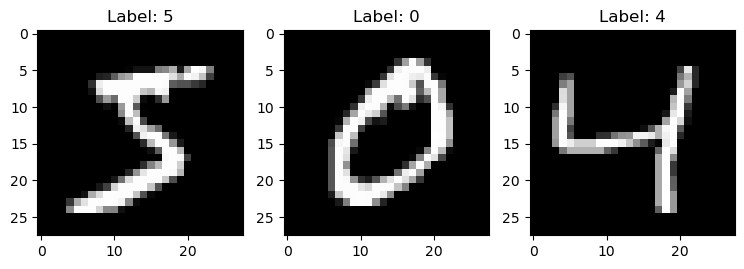

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Make a sanity check plot
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    image, label = mnist_train[i]
    axs[i].imshow(image.squeeze(0).numpy(), cmap="gray")
    axs[i].set_title(f"Label: {label}")

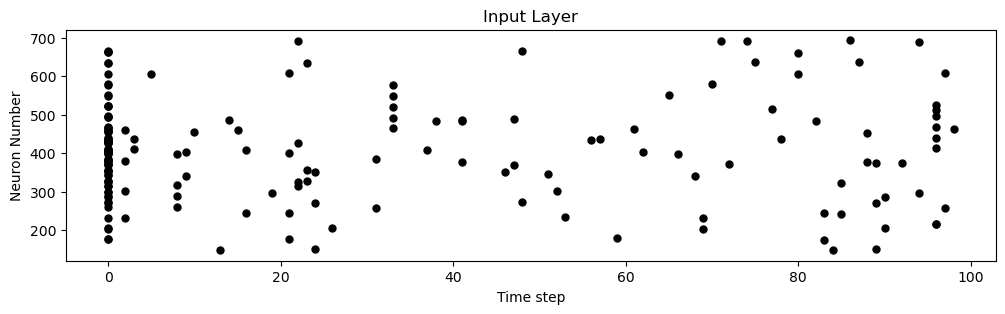

In [4]:
# Create dataloader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# --- The rest in this cell is just to show how to encode data into spikes ---

# Fetch a batch of data
data = iter(train_loader)
data_it, targets_it = next(data)

# Encode it into spikes
#   - linear, normalize, clip are IMPORTANT for the spikegen.latency function
#     details here: https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_1.html
spike_data = spikegen.latency(
    data_it, 
    num_steps=num_steps, 
    tau=25, 
    threshold=0.01, 
    linear=True, 
    normalize=True, 
    clip=True
)

# Plot to keep me sane
fig = plt.figure(facecolor="w", figsize=(12, 3))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 5].view(100, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [5]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
from IPython.display import HTML

# Select a single sample from the batch: [num_steps, 28, 28]
spike_data_sample = spike_data[:, 5, 0]  # first image in batch

# Create a figure/axis for the animation
fig, ax = plt.subplots(figsize=(4, 4))

# Generate the animation
anim = splt.animator(spike_data_sample, fig, ax, interval=7, cmap='binary')  # you can choose any colormap you like

# Display animation as HTML video in Jupyter
plt.close(fig)  # Avoids duplicate frame
HTML(anim.to_html5_video())


In [6]:
class EventConvPool(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size_conv: int,
            kernel_size_pool: int,
            stride_pool: int,
            threshold: float,
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size_conv,
            stride=1,
            padding=0
        )
        self.kernel_size_pool = kernel_size_pool
        self.stride_pool = stride_pool
        self.threshold = threshold

    def forward(self, input_spikes, num_steps):
        # input_spikes: [num_steps, batch, in_channels, height, width]
        batch_size = input_spikes.shape[1]
        device = input_spikes.device

        with torch.no_grad():
            dummy = self.conv(input_spikes[0])
        _, out_channels, H, W = dummy.shape

        membrane = torch.zeros(batch_size, out_channels, H, W, device=device)
        pooled_spikes_collected = []
        print("input_spikes.shape:", input_spikes.shape) if debug else None
        print("num_steps:", num_steps) if debug else None

        for t in range(num_steps):

            print(f"Time {t}")  if debug else None

            x = input_spikes[t]
            conv_out = self.conv(x)
            print("conv_out shape:", conv_out.shape) if debug else None
            membrane += conv_out

            mem_unfold = F.unfold(
                membrane,
                kernel_size=self.kernel_size_pool,
                stride=self.stride_pool
            )
            print("mem_unfold shape:", mem_unfold.shape) if debug else None
            window_area = self.kernel_size_pool * self.kernel_size_pool
            num_windows = mem_unfold.shape[2]

            mem_unfold = mem_unfold.view(
                batch_size,
                out_channels,
                window_area,
                num_windows
            )

            pooled_mem = mem_unfold.sum(dim=2)
            print("pooled_mem shape:", pooled_mem.shape) if debug else None
            spikes = (pooled_mem >= self.threshold)

            pooled_H = (H - self.kernel_size_pool) // self.stride_pool + 1
            pooled_W = (W - self.kernel_size_pool) // self.stride_pool + 1

            spikes_2d = spikes.view(
                batch_size,
                out_channels,
                pooled_H,
                pooled_W
            )
            pooled_spikes_collected.append(spikes_2d)
            print("spikes_2d shape:", spikes_2d.shape) if debug else None
            reset_mask = (mem_unfold >= self.threshold) & spikes.unsqueeze(2)
            mem_unfold = mem_unfold.masked_fill(reset_mask, 0.0)

            membrane = F.fold(
                mem_unfold.view(batch_size, out_channels * window_area, num_windows),
                output_size=(H, W),
                kernel_size=self.kernel_size_pool,
                stride=self.stride_pool
            )

        pooled_spikes_collected = torch.stack(pooled_spikes_collected, dim=0)
        return pooled_spikes_collected

In [7]:
class CustomSNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.event_convpool = EventConvPool(
            in_channels=1, out_channels=num_class,
            kernel_size_conv=3, kernel_size_pool=2, stride_pool=2,
            threshold=3.0
        )
        # Output size after conv (no padding, 3x3 kernel): 26x26
        # After 2x2 pool, stride 2: 13x13
        self.fc = nn.Linear(num_class * 13 * 13, num_classes)

    def forward(self, input_spikes):
        num_steps = input_spikes.shape[0]
        pooled_spikes = self.event_convpool(input_spikes, num_steps)  # [steps, batch, out_c, 13, 13]
        # Sum over time (rate coding readout)
        summed_spikes = pooled_spikes.sum(dim=0)  # [batch, out_c, 13, 13]
        flat = summed_spikes.view(summed_spikes.shape[0], -1)
        out = self.fc(flat.float())
        return out

In [8]:
EPOCHS = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomSNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

num_steps = 100  # Number of SNN time steps
train_loss = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        
        # Encode to spikes
        # Make sure your spikegen.latency or other encoder matches your earlier setup!
        batch_spike_input = spikegen.latency(
            data, 
            num_steps=num_steps, 
            tau=25, 
            threshold=0.01, 
            linear=True, 
            normalize=True, 
            clip=True
        ).to(device)  # shape [num_steps, batch, 1, 28, 28]
        
        optimizer.zero_grad()
        outputs = model(batch_spike_input)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)

        # Compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    avg_loss = running_loss / len(mnist_train)
    train_loss.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Acc: {100*correct/total:.2f}%')

print("Training finished.")


Epoch [1/15] | Loss: 41.4464 | Acc: 11.90%
Epoch [2/15] | Loss: 24.7520 | Acc: 17.64%
Epoch [3/15] | Loss: 14.2838 | Acc: 28.05%
Epoch [4/15] | Loss: 7.0548 | Acc: 51.50%
Epoch [5/15] | Loss: 7.8128 | Acc: 47.72%
Epoch [6/15] | Loss: 7.0384 | Acc: 57.52%
Epoch [7/15] | Loss: 5.1134 | Acc: 63.48%
Epoch [8/15] | Loss: 10.0741 | Acc: 58.31%
Epoch [9/15] | Loss: 3.3223 | Acc: 67.67%
Epoch [10/15] | Loss: 5.8107 | Acc: 65.65%
Epoch [11/15] | Loss: 6.3209 | Acc: 60.41%
Epoch [12/15] | Loss: 2.3133 | Acc: 71.87%
Epoch [13/15] | Loss: 11.2591 | Acc: 54.59%
Epoch [14/15] | Loss: 2.0462 | Acc: 75.12%
Epoch [15/15] | Loss: 6.4274 | Acc: 64.71%
Training finished.


In [9]:
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [10]:
model.eval()
num_steps = 100  # Use same value as in training

# Just evaluate one batch for demonstration
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Spike encode
test_spikes = spikegen.latency(
    images, 
    num_steps=num_steps, 
    tau=25, 
    threshold=0.01, 
    linear=True, 
    normalize=True, 
    clip=True
).to(device)

with torch.no_grad():
    outputs = model(test_spikes)
    predicted = outputs.argmax(dim=1)

for i in range(images.shape[0]):
    print(f"Sample {i}: Predicted = {predicted[i].item()} | Ground Truth = {labels[i].item()}")


Sample 0: Predicted = 7 | Ground Truth = 7
Sample 1: Predicted = 2 | Ground Truth = 2
Sample 2: Predicted = 1 | Ground Truth = 1
Sample 3: Predicted = 0 | Ground Truth = 0
Sample 4: Predicted = 4 | Ground Truth = 4
Sample 5: Predicted = 1 | Ground Truth = 1
Sample 6: Predicted = 4 | Ground Truth = 4
Sample 7: Predicted = 9 | Ground Truth = 9
Sample 8: Predicted = 5 | Ground Truth = 5
Sample 9: Predicted = 9 | Ground Truth = 9
Sample 10: Predicted = 0 | Ground Truth = 0
Sample 11: Predicted = 6 | Ground Truth = 6
Sample 12: Predicted = 9 | Ground Truth = 9
Sample 13: Predicted = 0 | Ground Truth = 0
Sample 14: Predicted = 1 | Ground Truth = 1
Sample 15: Predicted = 3 | Ground Truth = 5
Sample 16: Predicted = 9 | Ground Truth = 9
Sample 17: Predicted = 7 | Ground Truth = 7
Sample 18: Predicted = 6 | Ground Truth = 3
Sample 19: Predicted = 4 | Ground Truth = 4
Sample 20: Predicted = 9 | Ground Truth = 9
Sample 21: Predicted = 6 | Ground Truth = 6
Sample 22: Predicted = 4 | Ground Truth = 

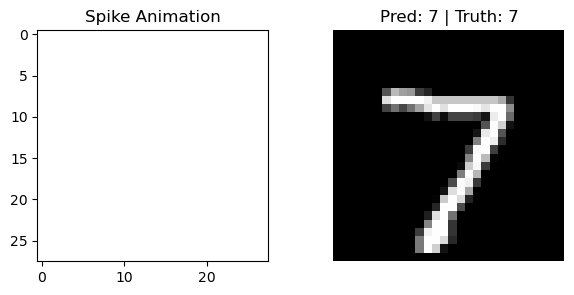

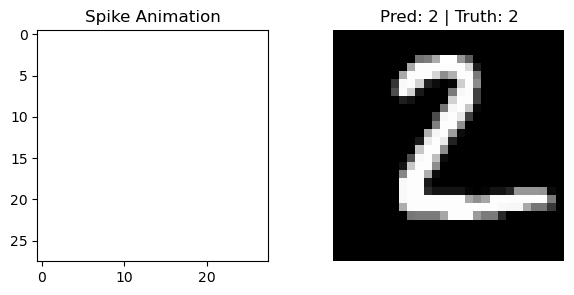

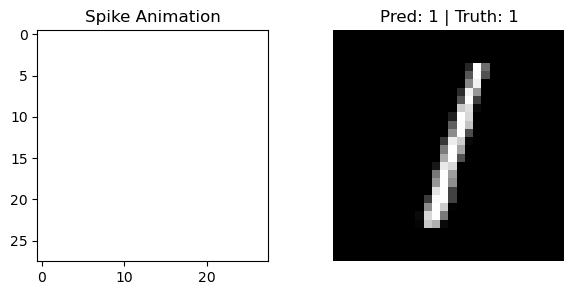

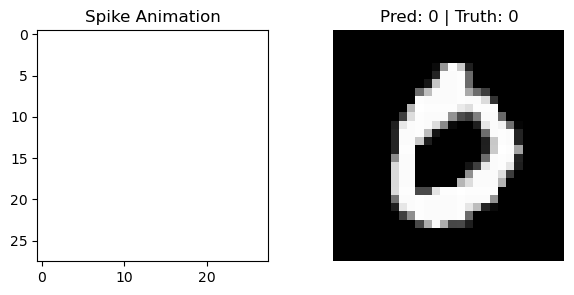

In [11]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Parameters
num_samples = 4
num_steps = 100  # match your training
batch_size = num_samples

# Get a batch of test samples
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images[:num_samples], labels[:num_samples]
images, labels = images.to(device), labels.to(device)

# Spike encode
spike_data = spikegen.latency(
    images,
    num_steps=num_steps,
    tau=25,
    threshold=0.01,
    linear=True,
    normalize=True,
    clip=True
).to(device)

with torch.no_grad():
    outputs = model(spike_data)
    predicted = outputs.argmax(dim=1)

# Plot each sample in a 4-row grid (spike animation left, static image right)
for i in range(num_samples):
    # Prepare spike train animation
    spike_sample = spike_data[:, i, 0].cpu()  # [num_steps, 28, 28]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Spike animation
    anim = splt.animator(spike_sample, fig, axs[0], interval=7, cmap='binary')
    axs[0].set_title("Spike Animation")

    # Static image on the right
    axs[1].imshow(images[i, 0].cpu(), cmap='gray')
    axs[1].set_title(f"Pred: {predicted[i].item()} | Truth: {labels[i].item()}")
    axs[1].axis('off')

    # Remove the blank axis (left) for animation; it's replaced by HTML video
    plt.close(fig)
    
    # Display side by side in Jupyter
    display(HTML(anim.to_html5_video()))
    display(fig)


In [12]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
import os

save_root = "pred"
os.makedirs(save_root, exist_ok=True)

model.eval()
num_steps = 100  # Use same value as in training

# Just evaluate one batch for demonstration
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Spike encode
test_spikes = spikegen.latency(
    images, 
    num_steps=num_steps, 
    tau=25, 
    threshold=0.01, 
    linear=True, 
    normalize=True, 
    clip=True
).to(device)

with torch.no_grad():
    outputs = model(test_spikes)
    predicted = outputs.argmax(dim=1)

for i in range(images.shape[0]):
    pred_class = predicted[i].item()
    true_class = labels[i].item()
    print(f"Sample {i}: Predicted = {pred_class} | Ground Truth = {true_class}")

    # Make subfolder for each predicted class
    class_dir = os.path.join(save_root, str(pred_class))
    os.makedirs(class_dir, exist_ok=True)
    
    # Generate spike animation
    spike_sample = test_spikes[:, i, 0].cpu()
    fig, ax = plt.subplots(figsize=(3, 3))
    anim = splt.animator(spike_sample, fig, ax, interval=7, cmap='binary')
    ax.set_title(f"Pred: {pred_class} | Truth: {true_class}")
    ax.axis('off')
    plt.close(fig)
    
    # Save as GIF
    gif_path = os.path.join(class_dir, f"spike_{i}_pred{pred_class}_true{true_class}.gif")
    anim.save(gif_path, writer="pillow", fps=1000//7)
    print(f"Saved {gif_path}")


Sample 0: Predicted = 7 | Ground Truth = 7
Saved pred\7\spike_0_pred7_true7.gif
Sample 1: Predicted = 2 | Ground Truth = 2
Saved pred\2\spike_1_pred2_true2.gif
Sample 2: Predicted = 1 | Ground Truth = 1
Saved pred\1\spike_2_pred1_true1.gif
Sample 3: Predicted = 0 | Ground Truth = 0
Saved pred\0\spike_3_pred0_true0.gif
Sample 4: Predicted = 4 | Ground Truth = 4
Saved pred\4\spike_4_pred4_true4.gif
Sample 5: Predicted = 1 | Ground Truth = 1
Saved pred\1\spike_5_pred1_true1.gif
Sample 6: Predicted = 4 | Ground Truth = 4
Saved pred\4\spike_6_pred4_true4.gif
Sample 7: Predicted = 9 | Ground Truth = 9
Saved pred\9\spike_7_pred9_true9.gif
Sample 8: Predicted = 5 | Ground Truth = 5
Saved pred\5\spike_8_pred5_true5.gif
Sample 9: Predicted = 9 | Ground Truth = 9
Saved pred\9\spike_9_pred9_true9.gif
Sample 10: Predicted = 0 | Ground Truth = 0
Saved pred\0\spike_10_pred0_true0.gif
Sample 11: Predicted = 6 | Ground Truth = 6
Saved pred\6\spike_11_pred6_true6.gif
Sample 12: Predicted = 9 | Ground Tr